<a href="https://colab.research.google.com/github/CristianMorasso/statistical_project/blob/master/Copia_di_statiscal_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Learning Project: ALFA Dataset Analysis


In [1]:
# Download the dataset from our git repository hosted on Github
! pip install sktime scikit-learn polars numpy
# !rm -rf statiscal_project
# !git clone https://github.com/CristianMorasso/statistical_project.git

LEN_DATASET = 45

DEPRECATION: beakerx-base 2.0.1 has a non-standard dependency specifier ipywidgets<8pandas,>=7.5.1. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of beakerx-base or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


# Intro


The project concerns the comparison of 3 different models (K-Nearest Neighbour, Convolutional Neural Network, Recurrent Neural Network) for a classification problem applied to the ALFA dataset.

**Project Outline**
1. Filling empty values with neighbors mean.
2. Split in windows, choose Dims and step (jump)
3. Split Train and Test
4. Feature selection
    1. RandomForest on Train
        * With error features
        * Without error features
    2. SelectKBest form SKLearn
5. Rebalancing of the train dataset using SMOTE
6. Pipeline Models
    * KNeighborsTimeSeriesClassifier
    * Convolutional Neural Network (CNN)
    * Recurrent Neural Network (RNN)
7. Model comparison
    * Learning Curve (?)
    * Confusion Matrix -> Accuracy, Recall, Precision, F1 



# Dataset


<img title="Autonomous flight example" width="500" src="./imgs/UAV.png">

The [ALFA Dataset](https://theairlab.org/alfa-dataset/) concerns several fault types in control surfaces of a fixed-wing Unmanned Aerial Vehicle (UAV) for use in Fault Detection and Isolation.

The data is collected using sensors, like GPS or wind estimation, local and global state (internal state of UAV).

The failures can be:
* Engine
* Aileron (can be used as specific or generic)
* Ruddler (can be used as specific or generic)
* Elevator (can be used as specific or generic)

[Img Traiettoria/esempio dati]()

*Mettere hist con distribuzioni classi*


DESCRIZIONE DATASET DEL PROF:
This dataset presents several fault types in control surfaces of a fixed-wing UAV for use in Fault Detection and Isolation (FDI) and Anomaly Detection (AD) research.
The dataset includes processed data for 47 autonomous flights with 23 sudden full engine failure scenarios and 24 scenarios for seven other types of sudden control surface (actuator) faults, with a total of 66 minutes of flight in normal conditions and 13 minutes of post-fault flight time. The platform used for collecting data is a custom modification of the Carbon Z
T-28 model plane

In [2]:
# Read the data from the csv files
import numpy as np
import pandas  as pd
import os
from random import shuffle

dataset_dir = "data"
dfs = [] # dataframe list

classToString= {0:"no_failure", 1:"elevator", 2:"engine", 3:"rudder",4:"ailerons"}
Y_fly = []
stringToClass = {}
for key, value in classToString.items():
  stringToClass[value] = key

series_counter = 0

for _, cl  in enumerate(os.listdir(dataset_dir)):
  path1 = os.path.join(dataset_dir, cl)

  # Get rid of files or bad dirs
  if not os.path.isdir(path1) or cl == "features":
    print(f"{cl} is not a dir or not useful!")
    continue
  
  for f in  os.listdir(path1):
    pathf = os.path.join(path1, f)
    df = pd.read_csv(pathf)

    # Fix the label field
    try:
      df["field.data"] = df["field.data"].apply(func=lambda x: stringToClass[cl] if int(x)>0 else 0)
      df = df.rename(columns={"field.data": "Y"})
    except:
      print(f"Error for {cl}")
      df["Y"]  = pd.Series([ 0 for _ in range(df.shape[0])])

    # Drop the time column!
    df = df.drop("%time", axis=1)

    # Save it
    Y_fly.append(stringToClass[cl])
    dfs.append(df)
    series_counter+=1

print(f"\nNumber of Time Series: {len(dfs)}")
assert len(dfs) == LEN_DATASET # We know the exact number from the repo


features is not a dir or not useful!
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
README.md is not a dir or not useful!
__init__.py is not a dir or not useful!

Number of Time Series: 45


In [3]:
df.columns

Index(['field.orientation.x', 'field.orientation.y', 'field.orientation.z',
       'field.angular_velocity.x', 'field.angular_velocity.y',
       'field.angular_velocity.z', 'field.linear_acceleration.x',
       'field.linear_acceleration.y', 'field.linear_acceleration.z', 'Y',
       'field.twist.linear.x', 'field.twist.linear.y', 'field.twist.linear.z',
       'field.twist.angular.x', 'field.twist.angular.y',
       'field.twist.angular.z', 'field.alt_error', 'field.aspd_error',
       'field.xtrack_error', 'delta_yaw', 'delta_pitch', 'delta_roll',
       'delta_x', 'delta_y', 'delta_z', 'delta_roll_airspeed'],
      dtype='object')

Text(0.5, 0.98, 'Showing dataset')

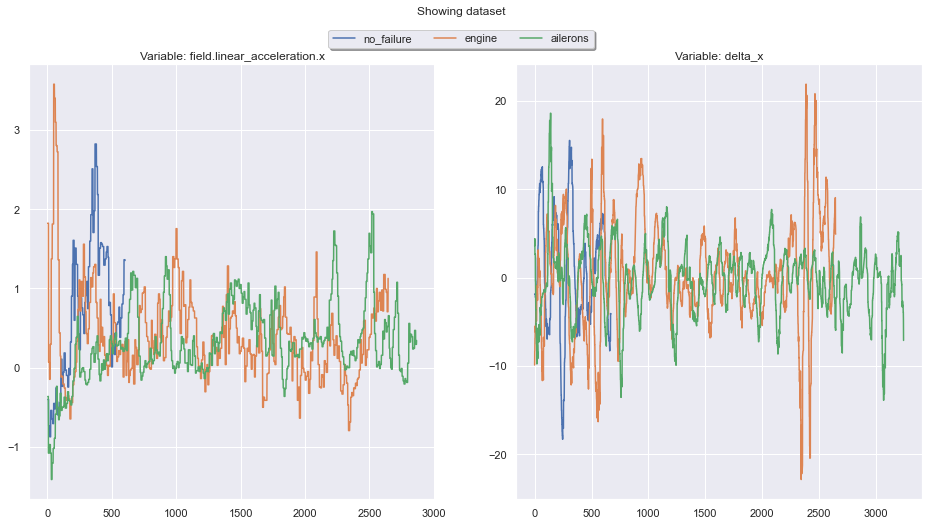

In [4]:
import matplotlib.pylab as plt
import seaborn as sns
Y_fly = np.array(Y_fly)
sns.set_theme()
sns.set_style()
fig, (left, right) = plt.subplots(1,2, figsize=(16,8))

left.plot(np.arange(dfs[np.where(Y_fly == 0)[0][0]]["delta_x"].shape[0]),dfs[np.where(Y_fly == 0)[0][0]]["field.linear_acceleration.x"] )
left.plot(np.arange(dfs[np.where(Y_fly == 2)[0][0]]["delta_x"].shape[0]),dfs[np.where(Y_fly == 2)[0][0]]["field.linear_acceleration.x"])
left.plot(np.arange(dfs[np.where(Y_fly == 4)[0][1]]["delta_x"].shape[0]),dfs[np.where(Y_fly == 4)[0][1]]["field.linear_acceleration.x"])
# plt.legend()
left.set_title("Variable: field.linear_acceleration.x")
right.plot(np.arange(dfs[np.where(Y_fly == 0)[0][2]]["delta_x"].shape[0]),dfs[np.where(Y_fly == 0)[0][2]]["delta_pitch"],label=classToString[0] )
right.plot(np.arange(dfs[np.where(Y_fly == 2)[0][2]]["delta_x"].shape[0]),dfs[np.where(Y_fly == 2)[0][2]]["delta_pitch"],label=classToString[2])
right.plot(np.arange(dfs[np.where(Y_fly == 4)[0][5]]["delta_x"].shape[0]),dfs[np.where(Y_fly == 4)[0][5]]["delta_pitch"],label=classToString[4])
right.set_title("Variable: delta_x")
fig.legend(loc="upper center", bbox_to_anchor=(0.5, .95),fancybox=True, shadow=True, ncol=3)
fig.suptitle("Showing dataset")
#trovare lunghezze corrette

In [5]:
# Shuffle the array of dataframes for so that classes are not contiguous
shuffle(dfs)

# Preprocessing

### Outline
* Removing not complitly shared features 
* Imputing of missing values
* Feature selection: SimpleKBest (from [SK-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)) and RandomForest
* Splitting in Windows
* Splitting in Train and Test
* Rebalancing of the dataset for the training

### Remove not usable features

In [6]:
from sklearn.impute import SimpleImputer
import numpy as np

# Remove useless features and inpute missing values
#
# finally use the mask on every timeseries of the OG dataframes list

# Remove all the features that are not shared by all Time Series
#
# Only use the variables that can be found in all the dataframes
features = []
# Get the biggest set:
# (We are considering that that the bigger set is just a superset and has all the other base features)
for df in dfs:
   features = max(features, df.columns.values, key=lambda x: len(x))
# Then get the set intersection of all of the features sets
features = set(features)
for df in dfs:
  features = features.intersection(set(df.columns.values))

# Apply the feature mask
print(len(features))
dfs = list(map(lambda x: x[list(features)] , dfs))

# Concat all the time series in as single dataframe for later :)
concatted_dfs = pd.concat(dfs)
concatted_y = concatted_dfs["Y"]
concatted_dfs = concatted_dfs.drop("Y", axis=1)

26


In [7]:
from sklearn.impute import SimpleImputer
import numpy as np

# Inpute the missing values first
dfs = list(map(lambda x: SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(x) , dfs))

### Feature Selection

##### With SelectKBest
(Link [Here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html))

Descrizione 

In [8]:
# Print the number of nans per per each columns
print(concatted_dfs.isnull().sum())
print(f"Length of Concatted Dataframes: {len(concatted_dfs)}")

field.orientation.x            291
field.twist.angular.x          143
delta_yaw                       57
field.orientation.y            291
field.linear_acceleration.y    291
field.linear_acceleration.x    291
field.angular_velocity.x       291
field.alt_error                 57
field.twist.angular.y          143
field.xtrack_error              57
delta_x                         59
delta_y                         59
field.angular_velocity.z       291
field.twist.linear.y           143
delta_roll_airspeed             60
field.twist.angular.z          143
delta_pitch                     57
delta_z                         59
field.linear_acceleration.z    291
field.orientation.z            291
field.twist.linear.x           143
field.angular_velocity.y       291
field.twist.linear.z           143
field.aspd_error                57
delta_roll                      59
dtype: int64
Length of Concatted Dataframes: 93670


In [9]:
from sklearn.feature_selection import SelectKBest
import numpy as np

# Inpute the nan values to the mean of the other entries value of the same column
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(concatted_dfs)
inp_out = imp.transform(concatted_dfs)

# Get the best 20 features of the dataset
columns_ = concatted_dfs.columns.values
feature_mask= SelectKBest(k=20).fit(inp_out, concatted_y).get_feature_names_out(columns_)

# ( Uses sklearn.feature_selection.f_classify )
print("Feature Mask:")
print(feature_mask)
print(f"Length of Feature Mask: {len(feature_mask)}")

Feature Mask:
['field.orientation.x' 'delta_yaw' 'field.orientation.y'
 'field.linear_acceleration.y' 'field.linear_acceleration.x'
 'field.alt_error' 'field.xtrack_error' 'delta_y'
 'field.angular_velocity.z' 'field.twist.linear.y' 'delta_roll_airspeed'
 'field.twist.angular.z' 'delta_pitch' 'delta_z'
 'field.linear_acceleration.z' 'field.orientation.z'
 'field.twist.linear.x' 'field.twist.linear.z' 'field.aspd_error'
 'delta_roll']
Length of Feature Mask: 20


#### With randomForest scores:

**Random Forest** is a powerful ensemble learning method used in machine learning for classification and regression tasks. It operates by constructing multiple decision trees during training and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. This approach enhances the accuracy and robustness of the model by reducing overfitting and variance. Random Forest is also valuable for *feature selection*, as it provides a measure of feature importance, helping to identify the most relevant features in a dataset.

In [10]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

def plot_feature_importances(model):
    fig_scale = 0.9
    n_features = len(concatted_dfs.columns) # take the features names from the Concatted DataFrame
    plt.figure(figsize=(7*fig_scale,5.4*fig_scale))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), concatted_dfs.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

Valutare se proporre entrambe le opzioni o solo una

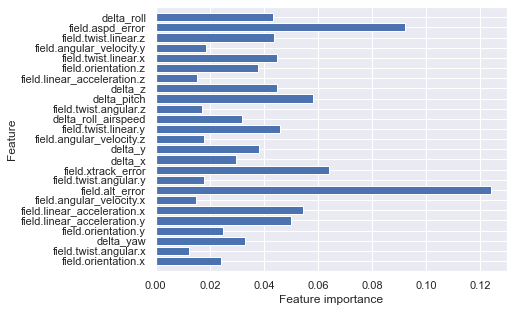

In [11]:
# WITH ERROR COLUMNS:
#
concatted_ndarray = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(concatted_dfs)
rf = RandomForestClassifier()
rf.fit(concatted_ndarray, concatted_y)
# Plot the feature importances
plot_feature_importances(rf)

# Select the n best features
n = 20
feature_mask = list(zip(concatted_dfs.columns, rf.feature_importances_))
feature_mask.sort(key=lambda x: x[1])
feature_mask = list(map(lambda x: x[0], feature_mask[:n]))

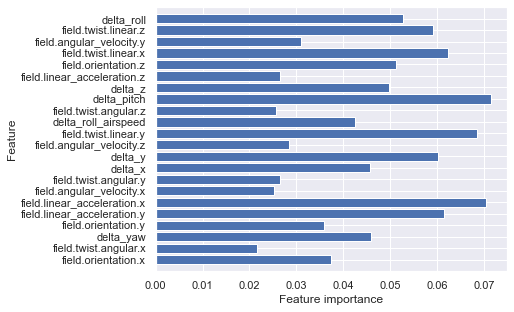

In [12]:
# WITHOUT ERROR COLUMNS:
#
concatted_dfs = concatted_dfs.drop(["field.alt_error", "field.xtrack_error", "field.aspd_error"], axis=1)
concatted_ndarray = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(concatted_dfs)
rf = RandomForestClassifier()
rf.fit(concatted_ndarray, concatted_y)
# Plot the feature importances
plot_feature_importances(rf)
# Select the n best features
n = 20 # Removing 7 (the ones that are clearly not performing (sub 0.03))
feature_mask = list(zip(concatted_dfs.columns, rf.feature_importances_))
feature_mask.sort(key=lambda x: x[1])
feature_mask = list(map(lambda x: x[0], feature_mask[:n]))

### Split the dataset into windows

We decided to split the time series in windows with size `window_length`, to increase the number of samples but mainly to produce online methods, widely used in Time series analysis. 

In [13]:
from sktime.split import SlidingWindowSplitter

splitted_ndarrays, window_length, step_length = [], 10, 10
splitter = SlidingWindowSplitter(window_length=window_length, step_length=step_length)
splitted_ndarrays = [ list(map(lambda x: x[0], splitter.split_series(df))) for df in dfs] # We are ignoring the forecasting horizon

print(f"Length of windowed dataset: {len(splitted_ndarrays)}")
assert len(splitted_ndarrays) == LEN_DATASET

Length of windowed dataset: 45


In [14]:
# Split into windows
_splitted_ndarrays = []
_splitted_ys = []
features = list(features)
y_index = features.index("Y") # Index of the Y column
features.pop(y_index)
#features = ["flight", "step", *features]

i = 0 # Number of windows

for sa in splitted_ndarrays:
  for a in sa:

    # Retrieve the label and save it separately
    _splitted_ys.append(np.max(a[:,y_index]))
    # And then delete it
    a = np.delete(a, y_index, axis=1)

    # np.concatenate([flight, step, a], axis=1)
    _splitted_ndarrays.append(a)
    i+=1 # Increase window counter

assert len(_splitted_ys) == len(_splitted_ndarrays)
print("n_windows: ", len(_splitted_ndarrays))

n_windows:  9342


### Split in Train and set:

In [15]:
import math
from random import shuffle

train_size = int(math.floor(len(_splitted_ndarrays)*0.8))
zipped = list(zip(_splitted_ndarrays, _splitted_ys))
shuffle(zipped)

X_train, X_test = list(map(lambda x: x[0], zipped[:train_size])), list(map(lambda x: x[0], zipped[train_size:]))
y_train, y_test = np.array(list(map(lambda x: x[1], zipped[:train_size]))), np.array(list(map(lambda x: x[1], zipped[train_size:])))

### Multi-Indexed Pandas Dataframe (sktime Panel)

In [16]:
# Finally let's create a multiIndexed pandas.Dataframe so that we can use our data with the sktime library
def toMultiIndexed(windows, feature_mask):
  _dfs = []
  for i, npVals in enumerate(windows):
    d = pd.DataFrame(npVals,columns=feature_mask)
    # The two columns for the multi-indexed Dataframe
    d.insert(0, "flight", [i for _ in range(int(npVals.shape[0]))], True)
    d.insert(1, "step", pd.RangeIndex(int(npVals.shape[0])), True)
    _dfs.append(d)

  _dfs = pd.concat(_dfs)
  # Set the 2 Indexes (onl  y flight is unique)
  _dfs = _dfs.drop_duplicates(subset=['flight', 'step'], keep='last')
  _dfs = _dfs.set_index(["flight", "step"])

  return _dfs

X_train, X_test = toMultiIndexed(X_train, features), toMultiIndexed(X_test, features)

In [17]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
X_train.head(20)

X_train: (74730, 25)
X_test: (18690, 25)
y_train: (7473,)
y_test: (1869,)


field.orientation.x  field.twist.angular.x   delta_yaw  \
flight step                                                           
0      0                0.026795              -0.147277    7.603027   
       1                0.026795              -0.240825    7.603027   
       2                0.026795              -0.240825    7.603027   
       3                0.026795              -0.240825    7.603027   
       4                0.026795              -0.240825    7.603027   
       5                0.026795              -0.240825    7.603027   
       6                0.026795              -0.240825    7.603027   
       7                0.026795              -0.240825    7.603027   
       8                0.026795              -0.240825    7.603027   
       9                0.006671              -0.240825    7.603027   
1      0                0.034477               0.129035    1.178772   
       1                0.034477               0.129035    1.178772   
       2                0.034477               0.129035    1.178772   
       3                0.034477               0.129035    1.178772   
       4                0.034477               0.129035    1.178772   
       5               -0.038453               0.129035    1.178772   
       6               -0.038453               0.111646 -357.640610   
       7               -0.038453               0.111646 -357.640610   
       8               -0.038453               0.111646 -357.640610   
       9               -0.038453               0.111646 -357.640610   

             field.orientation.y  field.linear_acceleration.y  \
flight step                                                     
0      0               -0.033842                     0.549172   
       1               -0.033842                     0.549172   
       2               -0.033842                     0.549172   
       3               -0.033842                     0.549172   
       4               -0.033842                     0.549172   
       5               -0.033842                     0.549172   
       6               -0.033842                     0.549172   
       7               -0.033842                     0.549172   
       8               -0.033842                     0.549172   
       9               -0.019387                     0.068647   
1      0                0.049552                     0.382459   
       1                0.049552                     0.382459   
       2                0.049552                     0.382459   
       3                0.049552                     0.382459   
       4                0.049552                     0.382459   
       5               -0.018868                     0.392266   
       6               -0.018868                     0.392266   
       7               -0.018868                     0.392266   
       8               -0.018868                     0.392266   
       9               -0.018868                     0.392266   

             field.linear_acceleration.x  field.angular_velocity.x  \
flight step                                                          
0      0                        0.049033                 -0.240825   
       1                        0.049033                 -0.240825   
       2                        0.049033                 -0.240825   
       3                        0.049033                 -0.240825   
       4                        0.049033                 -0.240825   
       5                        0.049033                 -0.240825   
       6                        0.049033                 -0.240825   
       7                        0.049033                 -0.240825   
       8                        0.049033                 -0.240825   
       9                       -0.088260                 -0.034373   
1      0                       -0.009807                  0.129035   
       1                       -0.009807                  0.129035   
       2                       -0.00980

# Models, Training and Performance

We choose to use three models (KNN, CNN, RNN), using the same pipeline, then we are showing the results with some metrics.




In [18]:
from sktime.datatypes import check_raise
from sklearn.model_selection import LearningCurveDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
from sktime.transformations.panel.padder import PaddingTransformer
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.transformations.panel.interpolate import TSInterpolator

class_labels = np.array(list(classToString.values()))

## K-Nearest Neighbour (KNN)

**K-Nearest Neighbour (K-NN)** is a supervised machine learning algorithm employed for classification and regression tasks. An advantage of this model is that it is non-parametric (it doesn't make any assumptions about the data distribution) and so is widely disposable in real-life scenarios.

The algorithm operates on the principle of *similarity*, where it predicts the label or value of a new data point by considering the labels/values of its K nearest neighbors in the training dataset.

Steps of the algorithm:
1. select the optimal K
2. calculating distances
3. finding the nearest neighbors
4. voting for classification or taking average for regression

It's easy to implement and has few hyperparameters: the value of K and the choice of the distance metric.

<div style="text-align: center;">
  <img src="./imgs/KNNExample.png" alt="KNN Example" style="width: 50%;"/>
  <p style="font-size: small;">Image source: <a href="https://www.geeksforgeeks.org/k-nearest-neighbours/" target="_blank">https://www.geeksforgeeks.org/k-nearest-neighbours/</a></p>
</div>


In [ ]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier(n_neighbors=5, distance='dtw')
knn.fit(X_train, y_train)

KNeighborsTimeSeriesClassifier(n_neighbors=5)

### Performances

Accuracy della KNN: 0.88

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.98      0.93      1551
         1.0       0.25      0.11      0.15         9
         2.0       0.85      0.48      0.62       143
         3.0       0.80      0.53      0.64        15
         4.0       0.70      0.32      0.44       151

    accuracy                           0.88      1869
   macro avg       0.70      0.49      0.56      1869
weighted avg       0.87      0.88      0.86      1869



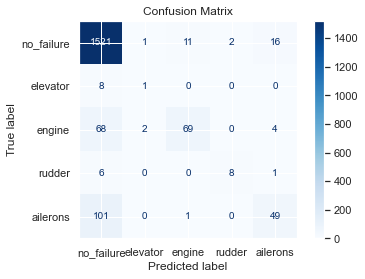

In [ ]:
y_pred_knn = knn.predict(X_test)

knn_acc = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy della KNN: {knn_acc:.2f}")

report = classification_report(y_test, y_pred_knn, zero_division = 0.0)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Convolutional Neural Network (CNN)

**Convolutional Neural Networks (CNNs)** are a class of deep learning algorithms commonly used for processing and analyzing visual data, but they have been applied also to other types of data, like the time series.

The key concepts at the basis of CNN are:
- *convolutional layers*: they can be a lot and each of them learns to detect different features, based on different filters at different resolutions
- *relu*: activation function that leads to a faster learning by mapping the negative values to zero and maintaining the positive ones
- *pooling layers*: simplifies the output by a non-linear downsampling (average or max), reducing the number of parameters the network has to learn

<div style="text-align: center;">
  <img src="./imgs/CNNExample.png" alt="CNN Example" style="width: 50%;"/>
  <p style="font-size: small;">Image source: <a href="https://it.mathworks.com/discovery/convolutional-neural-network.html" target="_blank">https://it.mathworks.com/discovery/convolutional-neural-network.html</a></p>
</div>
 
CNNs are suitable when you have a large amount of complex data, for example to learn the main features contained in an image, but also used with signals and time series. 
Some application fields are: medical imaging, audio elaboration, object detection, generation of synthetic data, and many others.

In [ ]:
from sktime.classification.deep_learning.cnn import CNNClassifier
from sktime.datatypes import check_raise

cnn = CNNClassifier(n_epochs=50, batch_size=4, kernel_size=3, avg_pool_size=1, n_conv_layers=3, loss='binary_crossentropy')
check_raise(X_train, mtype="pd-multiindex")
check_raise(y_train, mtype='np.ndarray')
cnn.fit(X_train, y_train)

CNNClassifier(avg_pool_size=1, batch_size=4, kernel_size=3,
              loss='binary_crossentropy', n_conv_layers=3, n_epochs=50)

### Performances

468/468 [==============================] - 1s 1ms/step
Accuracy: 0.86

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.99      0.92      1551
         1.0       0.00      0.00      0.00         9
         2.0       0.74      0.52      0.61       143
         3.0       0.00      0.00      0.00        15
         4.0       0.00      0.00      0.00       151

    accuracy                           0.86      1869
   macro avg       0.32      0.30      0.31      1869
weighted avg       0.78      0.86      0.81      1869



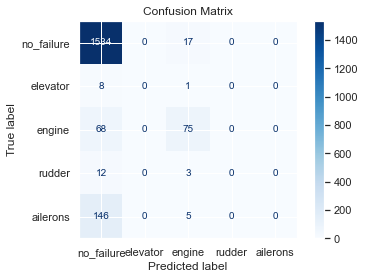

In [ ]:
y_pred_cnn = cnn.predict(X_test)

cnn_acc = accuracy_score(y_test, y_pred_cnn)
print(f"Accuracy: {cnn_acc:.2f}")

report = classification_report(y_test, y_pred_cnn, zero_division = 0.0)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels) #np.unique(y_test)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Recurrent Neural Network (RNN)

**Recurrent Neural Networks (RNNs)** are a class of neural networks designed for sequential data. Unlike traditional feedforward neural networks, RNNs have connections that form directed cycles, enabling them to maintain a "memory" of previous inputs in the sequence.

The most important feature in RNN is its *hidden state*, which remembers some information about a sequence until that moment. This state acts like a memory, allowing the net to remember the past information and use it to produce the next output.

<div style="text-align: center;">
  <img src="./imgs/RNNExample.png" alt="RNN Example" style="width: 50%;"/>
  <p style="font-size: small;">Image source: <a href="https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/" target="_blank">https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/</a></p>
</div>

RNNs are suitable for capturing temporal dependencies and relationships in sequential data, making them effective for tasks where context over time is important.

In [ ]:
from sktime.classification.deep_learning.rnn import SimpleRNNClassifier

rnn = SimpleRNNClassifier(n_epochs=50, batch_size=20, loss='binary_crossentropy')
rnn.fit(X_train, y_train)
# rnn.score(X_test, y_test)

RECURRENT NEURAL NETWORK


SimpleRNNClassifier(batch_size=20, loss='binary_crossentropy', n_epochs=50)

### Performances

94/94 [==============================] - 0s 1ms/step
Accuracy: 0.89

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      1551
         1.0       0.00      0.00      0.00         9
         2.0       0.96      0.71      0.82       143
         3.0       0.90      0.60      0.72        15
         4.0       0.00      0.00      0.00       151

    accuracy                           0.89      1869
   macro avg       0.55      0.46      0.50      1869
weighted avg       0.81      0.89      0.85      1869



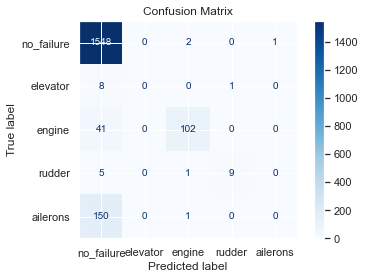

In [ ]:
y_pred_rnn = rnn.predict(X_test)

rnn_acc = accuracy_score(y_test, y_pred_rnn)
print(f"Accuracy: {rnn_acc:.2f}")

report = classification_report(y_test, y_pred_rnn, zero_division = 0.0)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_rnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
